IMT 2200 - Introducción a Ciencia de Datos<br>
**Pontificia Universidad Católica de Chile**<br>
**Instituto de Ingeniería Matemática y Computacional**<br>
**Semestre 2025-S2**<br>
**Profesor:** Rodrigo A. Carrasco <br>

---

## Proyecto de Investigación – Terremotos en Chile


## Pregunta 5:
## **Clasifica eventos según su potencial para establecer zonas de riesgo.**<br>

In [1]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
import folium
import webbrowser
import os


In [2]:
ruta = Path('..') / 'data' / 'query_limpio.csv'
df = pd.read_csv(ruta)

Este código implementa un sistema de clasificación de riesgo sísmico usando Machine Learning. El siguiente codigo es creado por la IA, el cual implementa un sistema de clasificación de riesgo sísmico usando Machine Learning. El modelo no predice terremotos futuros, sino que clasifica eventos (pasados o presentes) según su potencial de ser fuertes. 

In [3]:
# =================================
# 1. Variable objetivo
# =================================
df['riesgo'] = (df['mag'] >= 6).astype(int)  # terremoto fuerte = 1

features = ['latitude', 'longitude', 'depth', 'magError', 'rms', 'region', 'magType']
X = df[features]
y = df['riesgo']

# =================================
# 2. Dividir en entrenamiento y test
# =================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# =================================
# 3. Preprocesamiento con imputación
# =================================
numeric_features = ['latitude', 'longitude', 'depth', 'magError', 'rms']
categorical_features = ['region', 'magType']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),  # ⚠ imputación aplicada
            ('scaler', StandardScaler())
        ]), numeric_features),

        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # ⚠ imputación aplicada
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features),
    ]
)

# =================================
# 4. Modelo
# =================================
model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
])

model.fit(X_train, y_train)

# =================================
# 5. Evaluación
# =================================
preds = model.predict(X_test)
print(classification_report(y_test, preds))

# =================================
# 6. Creacion de coluna de predicted_risk
# =================================
X_test['predicted_risk'] = model.predict_proba(X_test)[:, 1]

#OpenAI. (2025). ChatGPT [modelo de lenguaje de gran tamaño]. https://www.openai.com/chatgpt 


              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1697
           1       0.59      0.35      0.44        99

    accuracy                           0.95      1796
   macro avg       0.78      0.67      0.71      1796
weighted avg       0.94      0.95      0.95      1796



In [4]:
X_test

,latitude,longitude,depth,magError,rms,region,magType,predicted_risk
5365,-32.9500,-71.9690,33.00,NaN,0.84,Valparaíso,mwc,0.035
93,-35.3300,-70.7256,109.00,0.032,0.71,Maule,mww,0.585
7846,-22.3570,-68.8280,119.00,NaN,1.20,Antofagasta,mb,0.000
2063,-32.3750,-71.0130,72.60,NaN,0.88,Valparaíso,mww,0.065
4113,-36.5210,-73.0340,35.00,NaN,0.84,Biobío,mb,0.000
...,...,...,...,...,...,...,...,...
881,-30.7945,-71.5750,35.69,0.208,0.84,Coquimbo,mb,0.000
2569,-33.3774,-72.2664,8.13,0.079,0.88,Valparaíso,mb,0.000
3783,-33.8550,-72.3240,36.00,NaN,0.87,Valparaíso,mwc,0.030
7529,-32.8780,-71.8180,33.00,NaN,1.20,Valparaíso,mw,0.180


Con estos datos ahora vamos a graficar

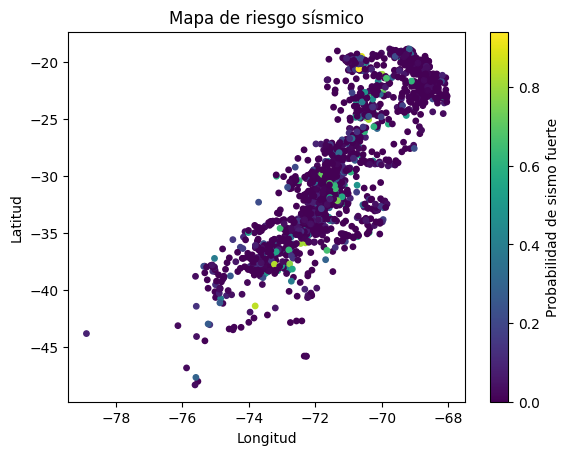

In [5]:
import matplotlib.pyplot as plt

plt.scatter(X_test['longitude'], X_test['latitude'], 
            c=X_test['predicted_risk'], s=15)
plt.colorbar(label='Probabilidad de sismo fuerte')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Mapa de riesgo sísmico')
plt.show()


Observamos que la mayoría de las zonas son de baja probabilidad, observamos que existen algunas ubicaciones con alta probabilidad, ahora vamos a clasificar creando un mapa interactivo que lo pueden encontrar en la carpeta data o corriendo el siguiente código.

In [6]:
mapa = folium.Map(location=[X_test['latitude'].mean(), X_test['longitude'].mean()], zoom_start=5)

# Función para asignar color según probabilidad de riesgo
def get_color(prob):
    if prob >= 0.8:
        return 'red'
    elif prob >= 0.3:
        return 'orange'
    else:
        return 'green'

# Agregar cada punto al mapa
for _, fila in X_test.iterrows():
    folium.CircleMarker(
        location=[fila['latitude'], fila['longitude']],
        radius=5 + fila['predicted_risk'] * 10,  # tamaño según probabilidad
        color=get_color(fila['predicted_risk']),
        fill=True,
        fill_opacity=0.6,
    ).add_to(mapa)
    
file_path = Path('..') / 'data' / 'mapa_riesgo.html'
mapa.save(file_path)

webbrowser.open('file://' + os.path.abspath(file_path))

True

Siendo los puntos amarillo menor al 30%, verde entre el 30% al 80% y rojo los de mayor a 80%

Ahora grafiquemos solo los de mayor al 70%

In [7]:
df_alto_riesgo = X_test[X_test['predicted_risk'] >= 0.7]

mapa = folium.Map(location=[df_alto_riesgo['latitude'].mean(), df_alto_riesgo['longitude'].mean()],
                  zoom_start=5)

for _, fila in df_alto_riesgo.iterrows():
    folium.CircleMarker(
        location=[fila['latitude'], fila['longitude']],
        radius=5 + fila['predicted_risk'] * 10,
        color='red',
        fill=True,
        fill_opacity=0.7,
    ).add_to(mapa)

file_path = Path('..') / 'data' / 'mapa_alto_riesgo.html'
mapa.save(file_path)

webbrowser.open('file://' + os.path.abspath(file_path))

True

Con esto podemos observar las zonas de mayor probabilidad a lo largo del país.